In [23]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [39]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 64
epochs = 30
IMG_HEIGHT = 150
IMG_WIDTH = 150

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.657.jpg  
  inflating: cats_and_dogs/train/dogs/dog.131.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.131.jpg  
  inflating: cats_and_dogs/train/dogs/dog.119.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.119.jpg  
  inflating: cats_and_dogs/train/dogs/dog.74.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.74.jpg  
  inflating: cats_and_dogs/train/dogs/dog.60.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_do

In [43]:
# 3
train_image_generator = ImageDataGenerator(rescale=1/255)
validation_image_generator = ImageDataGenerator(rescale=1/255)
test_image_generator = ImageDataGenerator(rescale=1/255)

train_data_gen = train_image_generator.flow_from_directory(
    directory=train_dir,                    # e.g. 'cats_and_dogs/train'
    target_size=(IMG_HEIGHT, IMG_WIDTH),    # resize to 150x150
    batch_size=batch_size,                  # e.g. 128
    class_mode="binary",                    # labels are 0/1 (cats/dogs)
    shuffle=True,                           # good for training
    seed=42
)
val_data_gen = validation_image_generator.flow_from_directory(
    directory=validation_dir,                    # e.g. 'cats_and_dogs/train'
    target_size=(IMG_HEIGHT, IMG_WIDTH),    # resize to 150x150
    batch_size=batch_size,                  # e.g. 128
    class_mode="binary",                    # labels are 0/1 (cats/dogs)
    shuffle=True,                           # good for training
    seed=42
)
test_data_gen = test_image_generator.flow_from_directory(
    directory=PATH,                    # e.g. 'cats_and_dogs/train'
    target_size=(IMG_HEIGHT, IMG_WIDTH),    # resize to 150x150
    batch_size=batch_size,                  # e.g. 128                   # labels are 0/1 (cats/dogs)
    shuffle=False, # good for training
    classes=['test'],
    seed=42
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


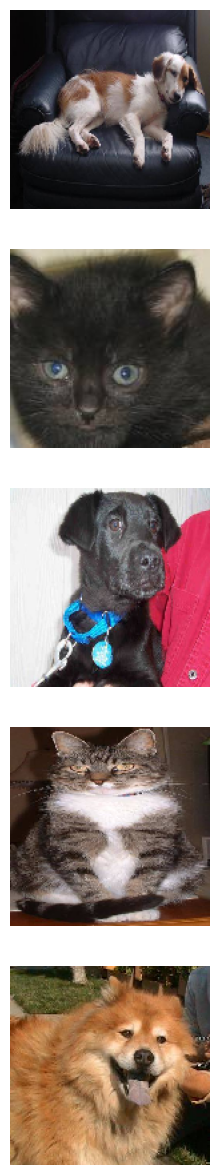

In [44]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [45]:
# 5
train_image_generator = ImageDataGenerator(
    rescale=1 /255,            # convert pixel values from 0-255 to 0-1
    rotation_range=20,         # randomly rotate pictures up to 20 degrees
    width_shift_range=0.2,     # randomly move pictures left or right by 20%
    height_shift_range=0.2,    # randomly move pictures up or down by 20%
    shear_range=0.15,          # slightly slant (shear) the picture
    zoom_range=0.15,           # randomly zoom in or out a bit
    horizontal_flip=True,      # randomly flip pictures left↔right
    fill_mode='nearest'        # fill empty pixels after shifting or rotating
)


Found 2000 images belonging to 2 classes.


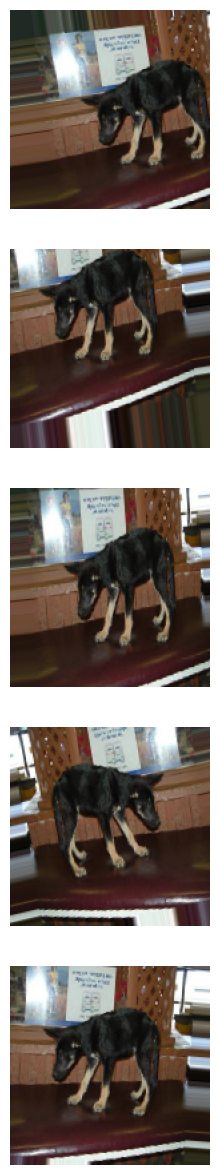

In [46]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [47]:
# 7

from tensorflow.keras import layers
model = Sequential([
    # Block 1
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.MaxPooling2D((2, 2)),

    # Block 2
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    # Block 3
    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    # Head
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation="relu"),
    layers.Dense(1, activation="sigmoid")   # binary: cats vs dogs
])

# Optimizer
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy']
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
# 8
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 542ms/step - accuracy: 0.4929 - loss: 0.8592 - val_accuracy: 0.4979 - val_loss: 0.6924
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.5000 - loss: 0.6928 - val_accuracy: 0.5000 - val_loss: 0.6921
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 443ms/step - accuracy: 0.5118 - loss: 0.6923 - val_accuracy: 0.5021 - val_loss: 0.6828
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5156 - loss: 0.6850 - val_accuracy: 0.4990 - val_loss: 0.6836
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 441ms/step - accuracy: 0.4946 - loss: 0.6902 - val_accuracy: 0.6083 - val_loss: 0.6716
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6562 - loss: 0.6852 - val_accuracy: 0.5188 - val_loss: 0.6783
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 440ms/step - accuracy: 0.5579 - loss: 0.6820 - val_accuracy: 0.5521 - val_loss: 0.6864
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.4688 - loss: 0.6919 - val_accuracy: 0.

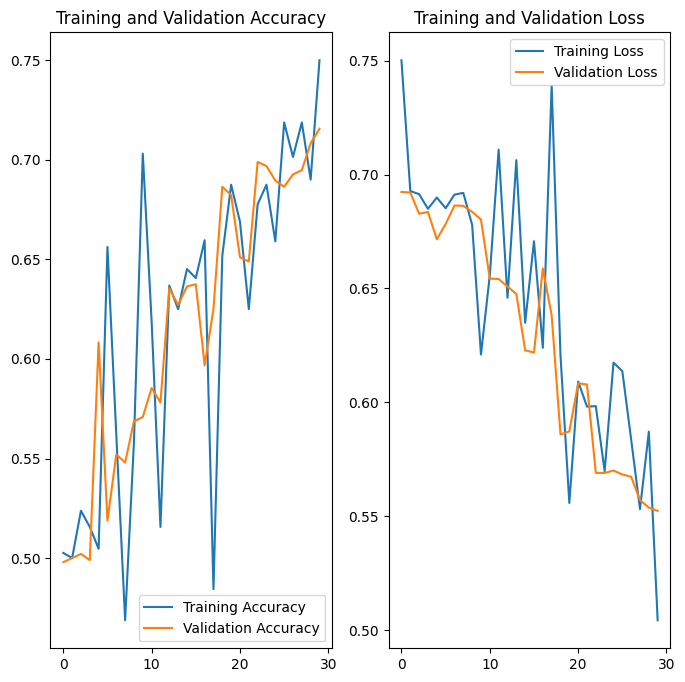

In [49]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [50]:
# check with test data
probabilities = model.predict(test_data_gen).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


In [51]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 72.0% of the images of cats and dogs.
You passed the challenge!


##Source

This is my Free Code Camp training project solution:
https://www.freecodecamp.org/learn/machine-learning-with-python/machine-learning-with-python-projects/cat-and-dog-image-classifier